# Time Series Analysis and Forecasting

## Import libraries and data

In [66]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [67]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

In [68]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()


Order Date    0
Sales         0
dtype: int64

In [69]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## Indexing with Time Series Data

In [70]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [71]:
Y=furniture['Sales'].resample('MS').mean()

## Create lag features


Dataset shape: (21, 12)
Fold RMSE: 1950.0523
Fold RMSE: 2410.2919
Fold RMSE: 1770.7547
Fold RMSE: 2031.8333
Fold RMSE: 588.4469


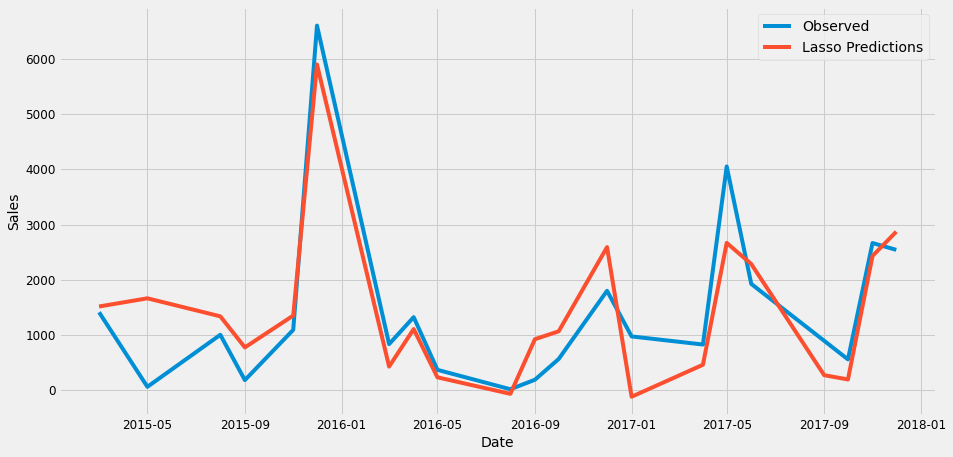

In [72]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline


for lag in range(1,13):
    furniture[f'lag_{lag}'] = Y.shift(lag)
furniture.dropna(inplace=True)


X= furniture.drop(columns=['Sales'])
y = furniture['Sales']

print("Dataset shape:", X.shape)


tscv = TimeSeriesSplit(n_splits=5)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1))
])

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    print(f'Fold RMSE: {rmse:.4f}')

# Fit the model on the entire dataset
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Observed')
plt.plot(y.index, y_pred, label='Lasso Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
    

## Visualizing Furniture Sales Time Series Data

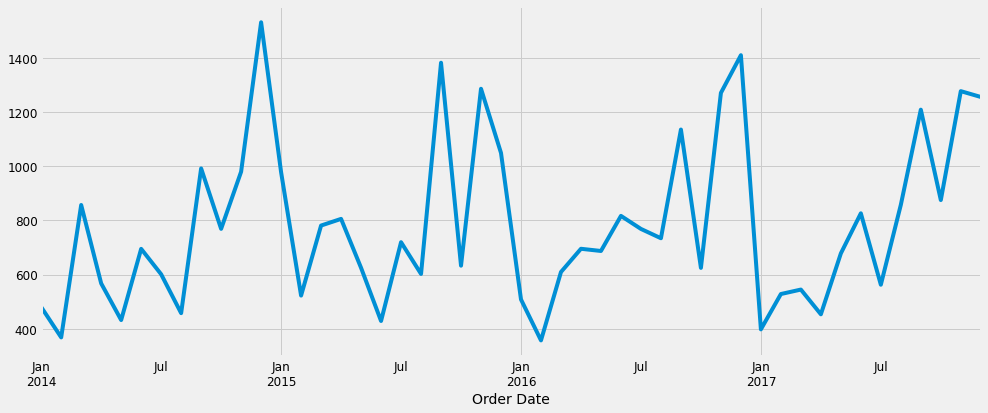

In [84]:
Y.plot(figsize=(15, 6))
plt.show()

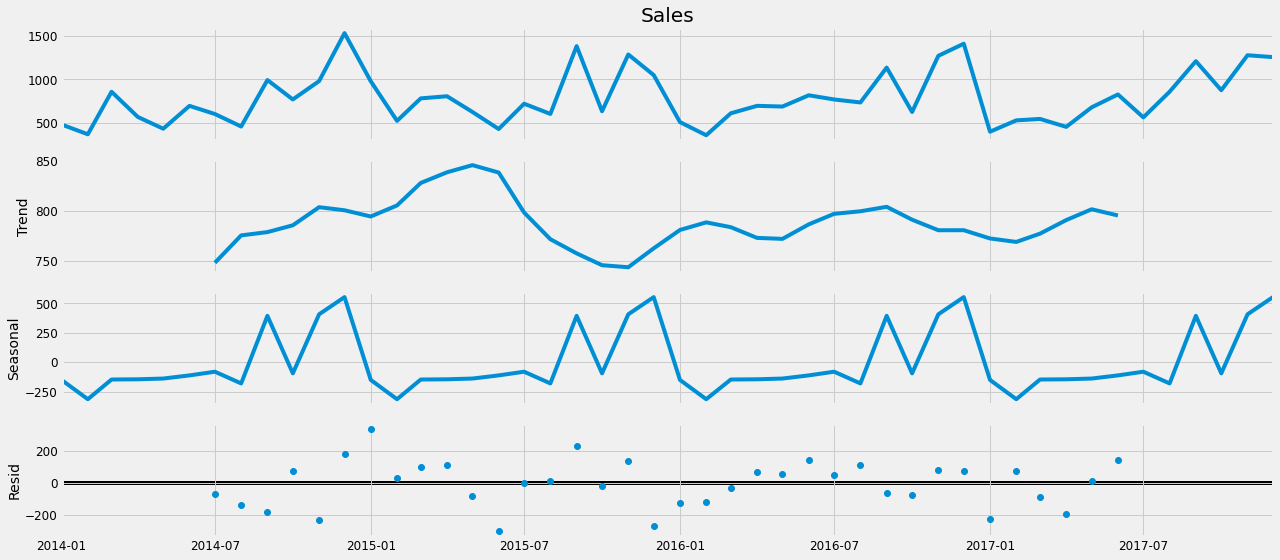

In [85]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8


decoposition = sm.tsa.seasonal_decompose(Y, model='additive')
fig= decoposition.plot()
plt.show()

## Time Series of Furniture vs. Office Supplies

In [102]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

## Data Exploration

In [103]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


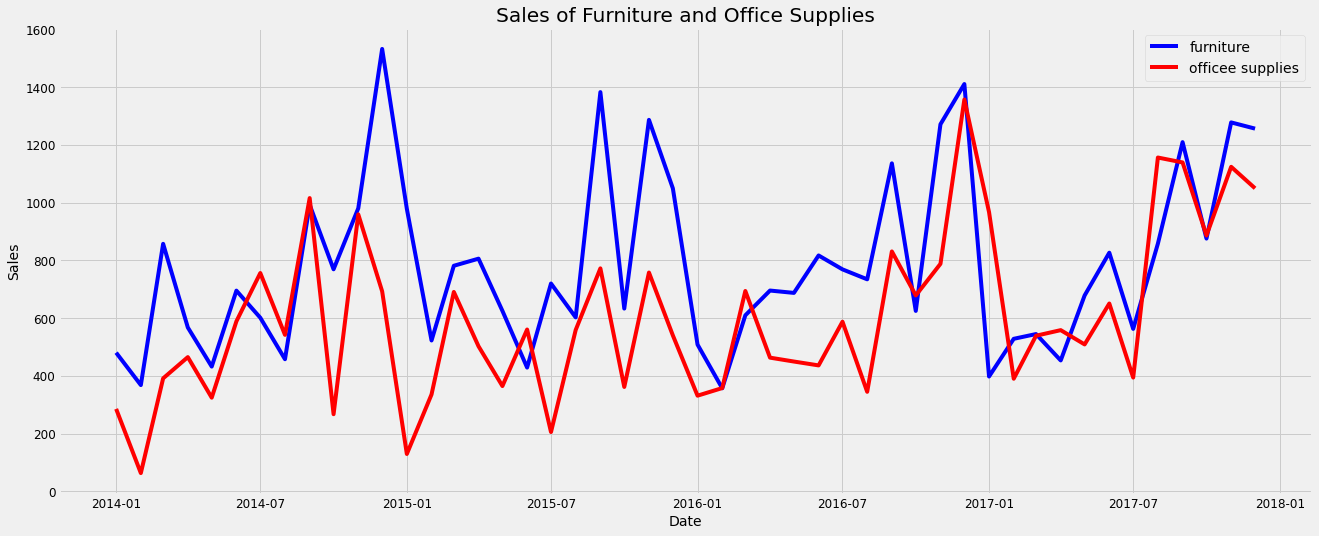

In [104]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'officee supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [105]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


## Tiime Series Modeling with Prophet

12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1296x432 with 0 Axes>

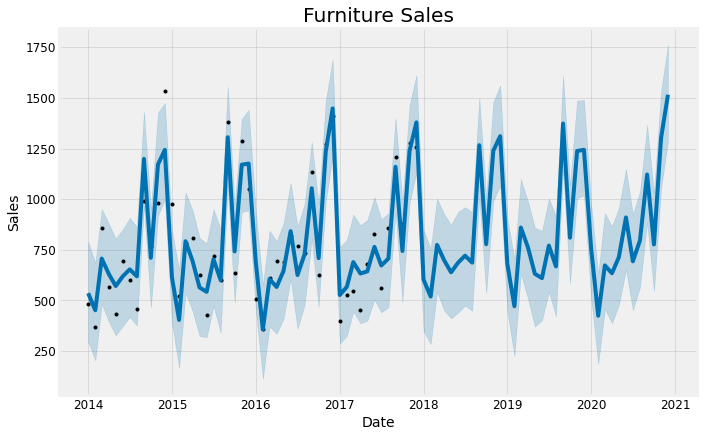

In [106]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize=(18,6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

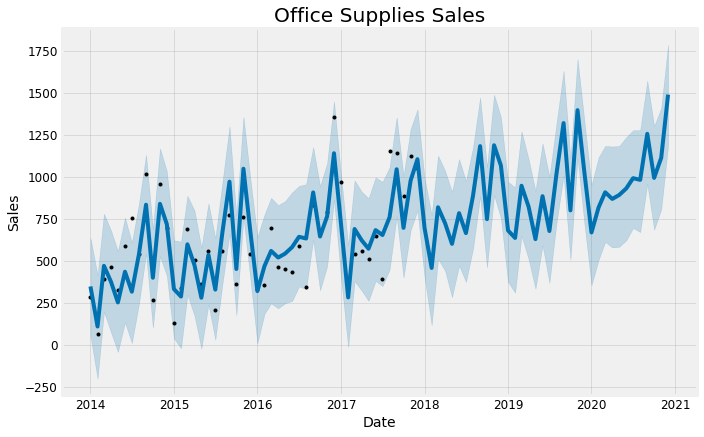

In [107]:
plt.figure(figsize=(18,6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

## Compare Forecasts

In [108]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,295.223975,789.156319,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,204.082484,685.611449,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,482.502409,950.499975,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,394.595725,878.621452,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,327.607099,805.266388,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


## Trend and Forecast Visualization

Text(0.5, 1.0, 'Furniture vs. Office Supplies Sales Trend')

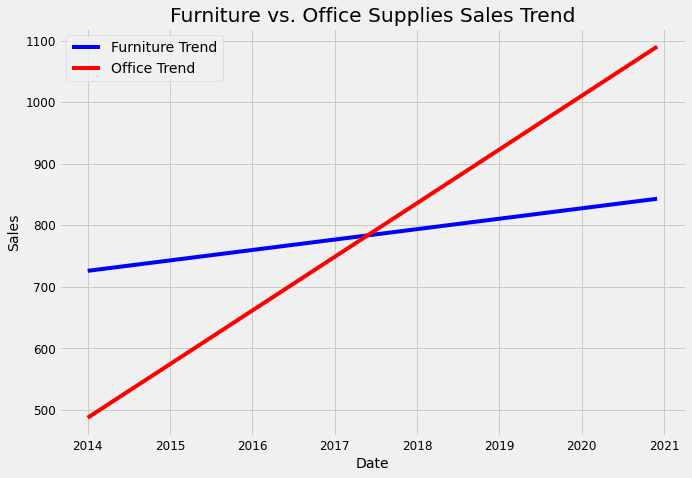

In [109]:
plt.figure(figsize=(10,7))
Furniture_trend = plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label='Furniture Trend')
Office_trend = plt.plot(forecast['Date'], forecast['office_trend'], 'r-', label='Office Trend')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')

Text(0.5, 1.0, 'Furniture vs. Office Supplies Estimate')

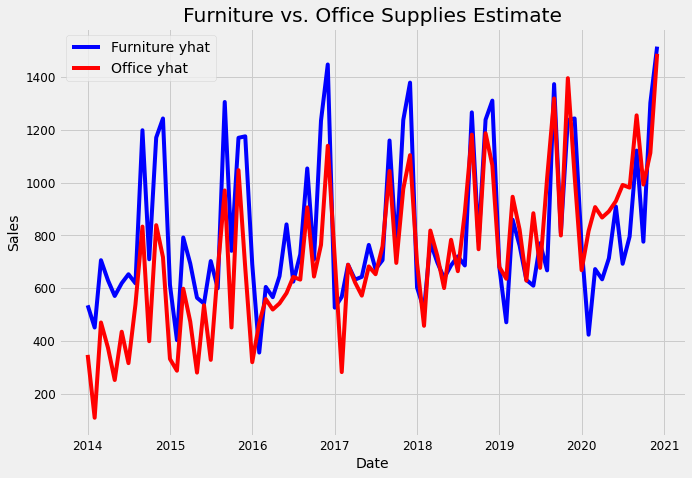

In [110]:
plt.figure(figsize=(10,7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label='Furniture yhat')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-', label='Office yhat')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')

## Trends and Patterns

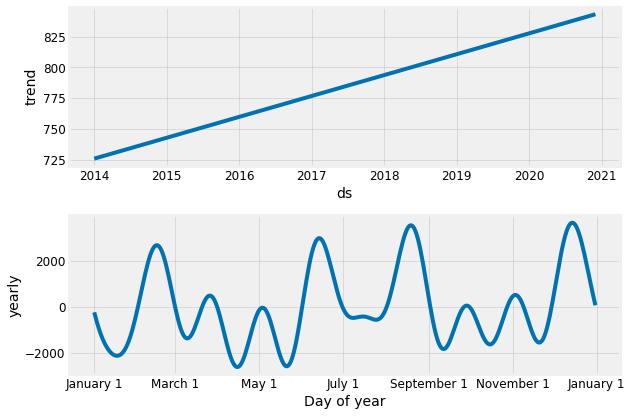

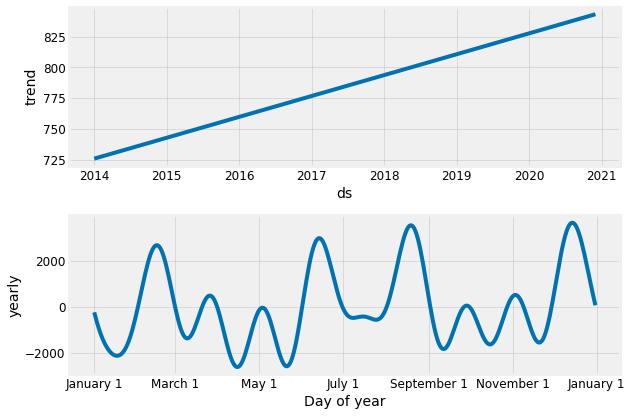

In [111]:
furniture_model.plot_components(furniture_forecast)

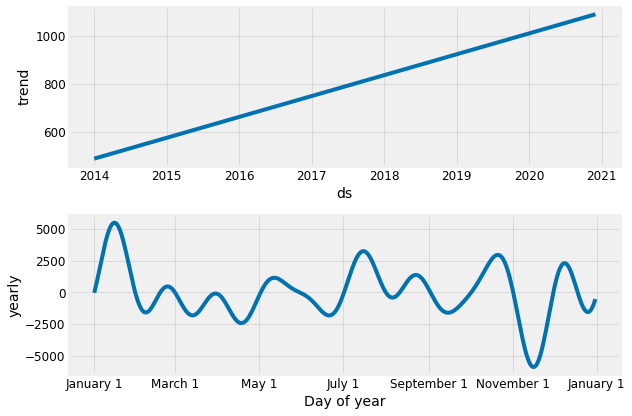

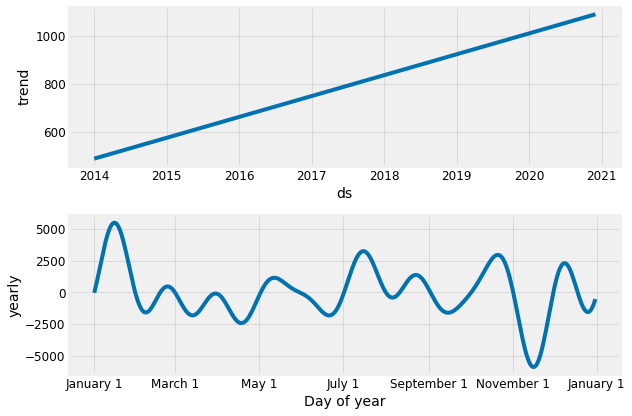

In [112]:
office_model.plot_components(office_forecast)